In [62]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('train_features1.pkl',mode='rb')as file:
    train_features1=pickle.load(file)
with open('train_labels.pkl',mode='rb')as file:
    train_labels=pickle.load(file)
with open('test_features1.pkl',mode='rb')as file:
    test_features1=pickle.load(file)
with open('test_labels.pkl',mode='rb')as file:
    test_labels=pickle.load(file)
with open('dataframe.pkl',mode='rb')as file:
    df=pickle.load(file)

In [3]:
print(train_features1.shape)
print(test_features1.shape)

(1891, 300)
(334, 300)


# Cross Validation

In [4]:
rf = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


In [8]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = list(range(20,100,5))
#max_depth.append(None)
 
# min_samples_split
min_samples_split = [2, 5, 10, 15]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [9]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=60,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(train_features1, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 60 candidates, totalling 180 fits
FINISHED--------------------


In [10]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 85, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9370730930160406


# Grid Search Cross Validation

In [14]:
# Create the parameter grid based on the results of random search 
bootstrap = [False,True]
max_depth = [80,85,90]
max_features = ['auto']
min_samples_leaf = [1, 2]
min_samples_split = [10,15]
n_estimators = [600,650]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features1, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
FINISHED--------------------


In [15]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 600}

The mean accuracy of a model with these hyperparameters is:
0.9317333333333333


In [16]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='auto',
                       min_samples_leaf=2, min_samples_split=15,
                       n_estimators=600, random_state=8)

In [17]:
best_rfc.fit(train_features1, train_labels)

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='auto',
                       min_samples_leaf=2, min_samples_split=15,
                       n_estimators=600, random_state=8)

In [18]:
rfc_pred = best_rfc.predict(test_features1)

In [19]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_labels, best_rfc.predict(train_features1)))

The training accuracy is: 
0.9989423585404548


In [21]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_labels, rfc_pred))

The test accuracy is: 
0.9251497005988024


In [56]:
 # Classification report
print("Classification report for Random Forest model")
print(classification_report(test_labels,rfc_pred))

Classification report for Random Forest model
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.91      0.88      0.90        49
           2       0.96      0.90      0.93        60
           3       0.85      0.98      0.91        81
           4       0.97      0.89      0.93        72

    accuracy                           0.93       334
   macro avg       0.93      0.92      0.92       334
weighted avg       0.93      0.93      0.93       334



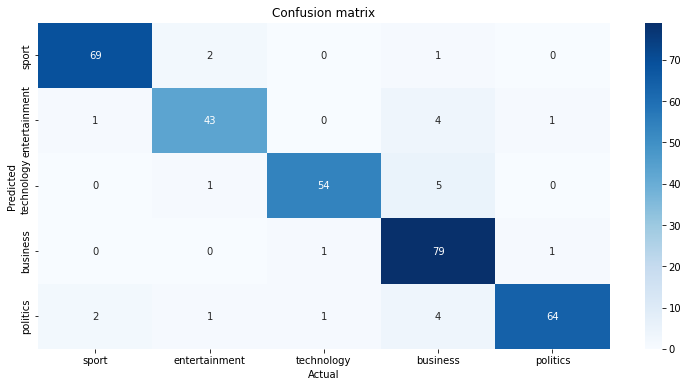

In [55]:
aux_df = df[['Category', 'CategoryID']].drop_duplicates().sort_values('CategoryID')
conf_matrix = confusion_matrix(test_labels, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig('Random_forest1_confision.png',bbox_inches = "tight")

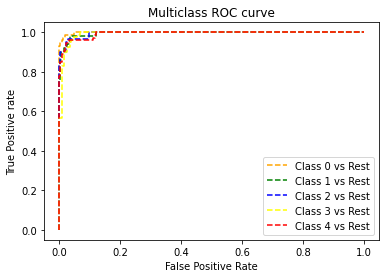

In [60]:
fpr = {}
tpr = {}
thresh ={}
y_prob_pred_cnb = best_rfc.predict_proba(test_features1)
n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels, y_prob_pred_cnb[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC');

In [63]:
roc_auc_score(test_labels, y_prob_pred_cnb, multi_class='ovo', average='weighted')

0.9947519761120239

# Second features

In [36]:
with open('train_features2.pkl',mode='rb')as file:
    train_features2=pickle.load(file)
with open('test_features2.pkl',mode='rb')as file:
    test_features2=pickle.load(file)

In [37]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = list(range(20,100,5))
#max_depth.append(None)
 
# min_samples_split
min_samples_split = [2, 5, 10, 15]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [38]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=60,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(train_features2, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 60 candidates, totalling 180 fits
FINISHED--------------------


In [39]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9434206223429676


In [40]:
 # Create the parameter grid based on the results of random search 
bootstrap = [False,True]
max_depth = [25,30,35]
max_features = ['sqrt']
min_samples_leaf = [1, 2]
min_samples_split = [1,4]
n_estimators = [600,650]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features2, train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
FINISHED--------------------


In [41]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 600}

The mean accuracy of a model with these hyperparameters is:
0.9397333333333333


In [42]:
best_rfc2 = grid_search.best_estimator_
best_rfc2

RandomForestClassifier(max_depth=30, min_samples_split=4, n_estimators=600,
                       random_state=8)

In [43]:
best_rfc2.fit(train_features2, train_labels)

RandomForestClassifier(max_depth=30, min_samples_split=4, n_estimators=600,
                       random_state=8)

In [44]:
rfc_pred2 = best_rfc2.predict(test_features2)

In [45]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_labels, best_rfc2.predict(train_features2)))

The training accuracy is: 
1.0


In [46]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_labels, rfc_pred2))

The test accuracy is: 
0.9311377245508982


In [47]:
 # Classification report
print("Classification report")
print(classification_report(test_labels,rfc_pred2))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.92      0.90      0.91        49
           2       0.96      0.92      0.94        60
           3       0.86      0.96      0.91        81
           4       0.97      0.90      0.94        72

    accuracy                           0.93       334
   macro avg       0.94      0.93      0.93       334
weighted avg       0.93      0.93      0.93       334



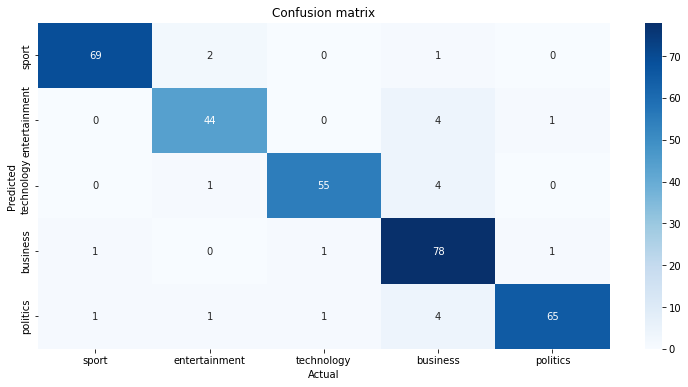

In [48]:
aux_df = df[['Category', 'CategoryID']].drop_duplicates().sort_values('CategoryID')
conf_matrix = confusion_matrix(test_labels, rfc_pred2)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

# base model

In [49]:
base_model = RandomForestClassifier()
base_model.fit(train_features1,train_labels)
accuracy_score(test_labels, base_model.predict(test_features1))

0.9221556886227545

In [50]:
best_rfc.fit(train_features1,train_labels)
accuracy_score(test_labels, best_rfc.predict(test_features1))


0.9251497005988024

In [51]:
base_model = RandomForestClassifier()
base_model.fit(train_features2,train_labels)
accuracy_score(test_labels, base_model.predict(test_features2))

0.9251497005988024

In [52]:
best_rfc2.fit(train_features2,train_labels)
accuracy_score(test_labels, best_rfc2.predict(test_features2))

0.9311377245508982

In [53]:
d = {
     'Model': ['Random Forest1','Random Forest2'],
     'Training Set Accuracy': [accuracy_score(train_labels, best_rfc.predict(train_features1)),
                              accuracy_score(train_labels, best_rfc2.predict(train_features2))],
     'Test Set Accuracy': [accuracy_score(test_labels, rfc_pred),accuracy_score(test_labels, rfc_pred2)]
}

df_models_rfc = pd.DataFrame(d)
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest1,0.998942,0.925150
1,Random Forest2,1.000000,0.931138


In [64]:
df_models_rfc.to_pickle('RFC.accuracy.pkl')